# Imports and setting up viz

NB : conda lam1env (Python3.12)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *
from tools_hf import *
from tools_native import *
from tools_LIAISE import *
from tools_mesoNH import *

# sys.path.append('../../python_tools/aborella/PLOTS/')
# from datasets import *
sys.path.append('../../python_tools/aborella/UTIL/')
import xr_utils

In [2]:
psy.rcParams['auto_show'] = True
mpl.rcParams['figure.figsize'] = [10., 8.]

# Load MesoNH files and edit datasets

In [3]:
mesoNH_dir = '../../../mesoNH_simulations'

In [76]:
def format_MesoNH_outputs_basic(filename, ds_name=None):
    ds = xr.open_mfdataset(filename)
    ds.attrs['name']= ds_name

    rename_dict={
        'time':'start_time',
        'longitude':'lon',
        'latitude':'lat'
    }
    ds = ds.rename(rename_dict)

    # Add time coordinate
    # Assuming 'time' coordinate is the starting time.
    base_time = pd.to_datetime(ds["start_time"].isel(start_time=0).item())
    print(f"Base time for the dataset: {base_time}")
    # Create a timedelta for each hour
    hourly_offsets = pd.to_timedelta(ds["record"].values, unit='h')
    new_time_vals = base_time + hourly_offsets
    # Assign new_time as a new coordinate, linked to the 'record' dimension
    ds = ds.assign_coords(time=("record", new_time_vals))
    ds = ds.swap_dims({"record": "time"})
    #drop start_time and record
    ds = ds.drop_vars(['start_time'])
    ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)

    if 'LE_ISBA' in ds:
        ds = ds.rename({'LE_ISBA': 'flat'})
        ds['flat'].attrs['long_name'] = 'Latent Heat Flux on natural areas'
        ds['flat'].attrs['units'] = 'W m⁻²'
    if 'H_ISBA' in ds:
        ds = ds.rename({'H_ISBA': 'sens'})
        ds['sens'].attrs['long_name'] = 'Sensible Heat Flux on natural areas'
        ds['sens'].attrs['units'] = 'W m⁻²'
    if 'HU2M_ISBA' in ds:
        ds['rh2m'] = ds['HU2M_ISBA'] * 100.0 
        ds['rh2m'].attrs['long_name'] = 'Relative Humidity at 2m'
        ds['rh2m'].attrs['units'] = '%'
    if 'T2M_ISBA' in ds:
        ds = ds.rename({'T2M_ISBA': 't2m'})
        ds['t2m'].attrs['long_name'] = 'Temperature at 2m'
        # ds['t2m'] = ds['t2m'] - 273.15
        ds['t2m'].attrs['units'] = 'K'
    if 'SWD' in ds:
        #remove dimension 'start_time' from SWD
        ds['SWD'] = ds['SWD'].squeeze('start_time', drop=True)
        ds = ds.rename({'SWD': 'SWdnSFC'})
        ds['SWdnSFC'].attrs['long_name'] = 'Downward Shortwave Radiation at Surface'
        ds['SWdnSFC'].attrs['units'] = 'W m⁻²'
    if 'LWD' in ds:
        #remove dimension 'start_time' from LWD
        ds['LWD'] = ds['LWD'].squeeze('start_time', drop=True)
    if 'LWU' in ds:
        #remove dimension 'start_time' from LWU
        ds['LWU'] = ds['LWU'].squeeze('start_time', drop=True)
    if 'SWU' in ds:
        #remove dimension 'start_time' from SWU
        ds['SWU'] = ds['SWU'].squeeze('start_time', drop=True)
    if 'HBLTOP' in ds:
        #remove dimension 'start_time' from HBLTOP
        ds['HBLTOP'] = ds['HBLTOP'].squeeze('start_time', drop=True)

    #add specific humidity at 2m
    # ds=add_specific_humidity_2m(ds, assume_psol=True)

    return(ds)

In [77]:
filename='{}/LIAIS.1*.nc'.format(mesoNH_dir)
# filename='{}/LIAIS.1.UT10.nc'.format(mesoNH_dir)
ds_orig = format_MesoNH_outputs_basic(filename)
ds_orig

Base time for the dataset: 2021-07-14 01:00:00


<xarray.Dataset> Size: 2GB
Dimensions:       (time: 408, nj: 164, ni: 290)
Coordinates:
  * ni            (ni) float64 2kB 0.0 2e+03 4e+03 ... 5.76e+05 5.78e+05
  * nj            (nj) float64 1kB 0.0 2e+03 4e+03 ... 3.24e+05 3.26e+05
    lat           (nj, ni) float64 380kB dask.array<chunksize=(164, 290), meta=np.ndarray>
    lon           (nj, ni) float64 380kB dask.array<chunksize=(164, 290), meta=np.ndarray>
  * time          (time) datetime64[ns] 3kB 2021-07-14T01:00:00 ... 2021-07-31
    time_decimal  (time) float64 3kB 1.0 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 0.0
Data variables: (12/14)
    HBLTOP        (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    HU2M_ISBA     (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    sens          (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    flat          (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    LWD           (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    LWU           (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    ...            ...
    SWI3_ISBA     (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    SWU           (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    t2m           (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    TG1_ISBA      (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    TG3_ISBA      (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
    rh2m          (time, nj, ni) float64 155MB dask.array<chunksize=(1, 164, 290), meta=np.ndarray>
Attributes:
    MNH_cleanly_closed:  yes
    history:             Thu Jun 12 15:36:26 2025: ncecat -v HBLTOP,time,lati...
    NCO:                 netCDF Operators version 5.2.1 (Homepage = http://nc...
    name:                None

In [79]:
def format_MesoNH_outputs_4D(filename, ds_name=None):
    ds = xr.open_mfdataset(filename)
    ds.attrs['name']= ds_name


    rename_dict={
        # 'time':'start_time',
        'longitude':'lon',
        'latitude':'lat'
    }
    ds = ds.rename(rename_dict)

    # Add time coordinate
    # Assuming 'time' coordinate is the starting time.
    # base_time = pd.to_datetime(ds["start_time"].isel(start_time=0).item())
    # print(f"Base time for the dataset: {base_time}")
    # Create a timedelta for each hour
    # hourly_offsets = pd.to_timedelta(ds["record"].values, unit='h')
    # new_time_vals = base_time + hourly_offsets
    # # Assign new_time as a new coordinate, linked to the 'record' dimension
    # ds = ds.assign_coords(time=("record", new_time_vals))
    # ds = ds.swap_dims({"record": "time"})
    # #drop start_time and record
    # ds = ds.drop_vars(['start_time'])
    # ds = ds.assign_coords(time_decimal=ds.time.dt.hour + ds.time.dt.minute / 60)

    return ds

filename='{}/4D/LIAIS.1*.nc'.format(mesoNH_dir)
ds_4D = format_MesoNH_outputs_4D(filename)
ds_4D

<xarray.Dataset> Size: 54MB
Dimensions:      (time: 1, level: 66, nj: 26, ni: 37, nj_u: 164, ni_u: 290,
                  nj_v: 164, ni_v: 290, level_w: 90)
Coordinates: (12/15)
    lat          (nj, ni) float64 8kB dask.array<chunksize=(26, 37), meta=np.ndarray>
    latitude_u   (nj_u, ni_u) float64 380kB dask.array<chunksize=(164, 290), meta=np.ndarray>
    latitude_v   (nj_v, ni_v) float64 380kB dask.array<chunksize=(164, 290), meta=np.ndarray>
  * level        (level) float64 528B -2.0 2.0 6.12 ... 2.654e+03 2.835e+03
  * level_w      (level_w) float64 720B -4.0 0.0 4.0 ... 1.679e+04 1.813e+04
    lon          (nj, ni) float64 8kB dask.array<chunksize=(26, 37), meta=np.ndarray>
    ...           ...
  * ni_u         (ni_u) float64 2kB -1e+03 1e+03 3e+03 ... 5.75e+05 5.77e+05
  * ni_v         (ni_v) float64 2kB 0.0 2e+03 4e+03 ... 5.76e+05 5.78e+05
  * nj           (nj) float64 208B 9e+04 9.2e+04 9.4e+04 ... 1.38e+05 1.4e+05
  * nj_u         (nj_u) float64 1kB 0.0 2e+03 4e+03 ... 3.24e+05 3.26e+05
  * nj_v         (nj_v) float64 1kB -1e+03 1e+03 3e+03 ... 3.23e+05 3.25e+05
  * time         (time) datetime64[ns] 8B 2021-07-16T12:00:00
Data variables:
    RVT          (time, level, nj, ni) float64 508kB dask.array<chunksize=(1, 30, 26, 37), meta=np.ndarray>
    THT          (time, level, nj, ni) float64 508kB dask.array<chunksize=(1, 30, 26, 37), meta=np.ndarray>
    TKET         (time, level, nj, ni) float64 508kB dask.array<chunksize=(1, 30, 26, 37), meta=np.ndarray>
    UT           (time, level, nj_u, ni_u) float64 25MB dask.array<chunksize=(1, 30, 55, 97), meta=np.ndarray>
    VT           (time, level, nj_v, ni_v) float64 25MB dask.array<chunksize=(1, 30, 55, 97), meta=np.ndarray>
    WT           (time, level_w, nj, ni) float64 693kB dask.array<chunksize=(1, 30, 26, 37), meta=np.ndarray>
    ZS           (nj, ni) float64 8kB dask.array<chunksize=(26, 37), meta=np.ndarray>
    ZTOP         float64 8B ...
Attributes:
    MNH_cleanly_closed:  yes
    history:             Fri Jun 13 15:35:04 2025: ncks -v UT,VT,WT,THT,RVT,T...
    NCO:                 netCDF Operators version 5.2.1 (Homepage = http://nc...
    name:                None

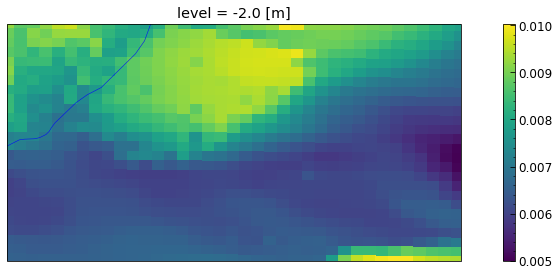

In [80]:
ds=ds_4D
level=2.000000e+00
var='RVT'

mean_ds = ds[var].mean(dim='time')
mean_ds = mean_ds[0,:,:]  # Select the specific level
# mean_ds
nice_map_mesoNH(mean_ds)



# Maps

/home/ptiengou/Documents/data_and_scripts/netcdf-scripts/python_notebooks/LMDZOR/../../python_tools/tools.py:616: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(polygon[:, 0], polygon[:, 1], 'r-', linewidth=2, c='red')


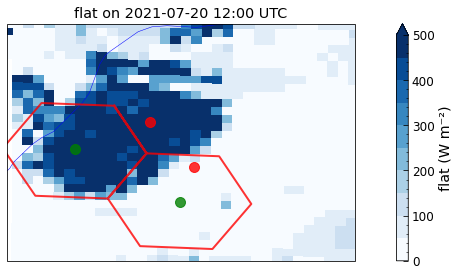

In [81]:
var='flat'
vmin=0
vmax=500
# vmin,vmax=None, None
cmap=blues
map_mesoNH_timestamp_restrict(ds_orig, 
                     var,
                     vmin=vmin, vmax=vmax, cmap=cmap,
                     timestamp='2021-07-20T12:00:00',
                     add_liaise=True,
                    lon_min=0.6, 
                    lon_max=1.4, 
                    lat_min=41.37, 
                    lat_max=41.92,
                    poly=both_cells
                     )

In [89]:
#list of all variables names in ds_orig
# ds_orig.data_vars.keys()
varlist=['HBLTOP', 'sens', 'flat', 'rh2m', 't2m',  'LWD', 'LWU', 'SWdnSFC',
          'SWI1_ISBA', 'SWI3_ISBA', 'TG1_ISBA', 'TG3_ISBA']

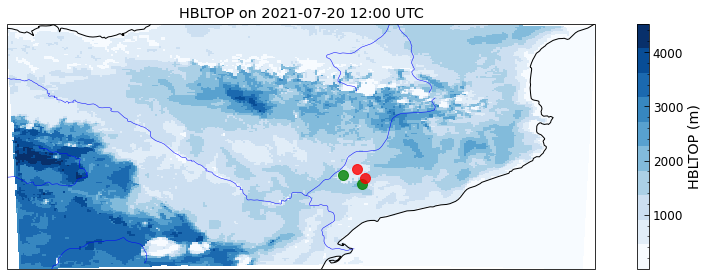

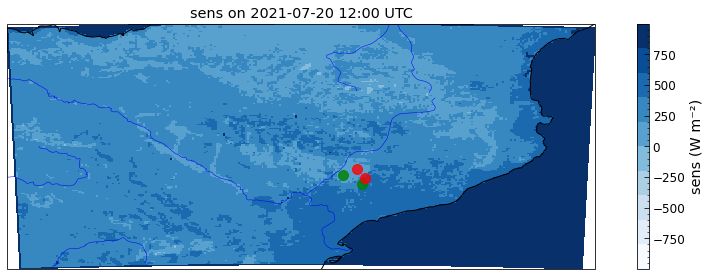

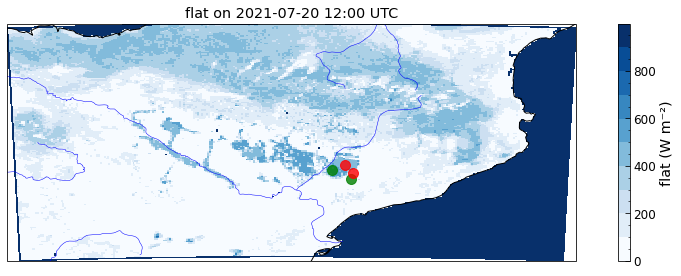

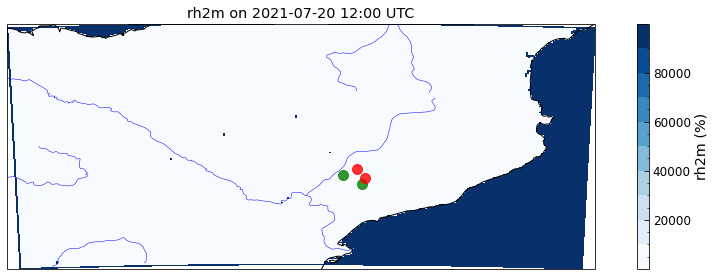

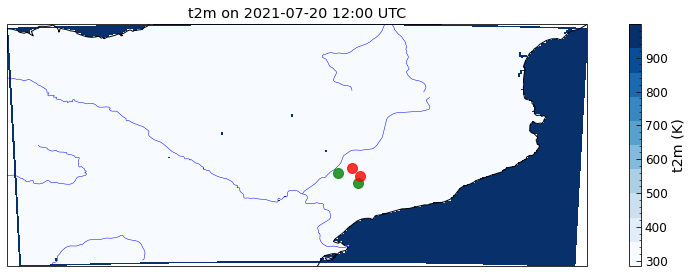

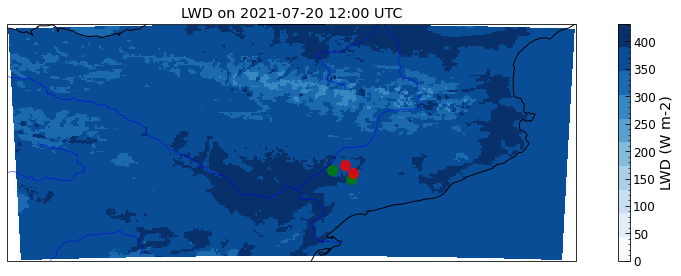

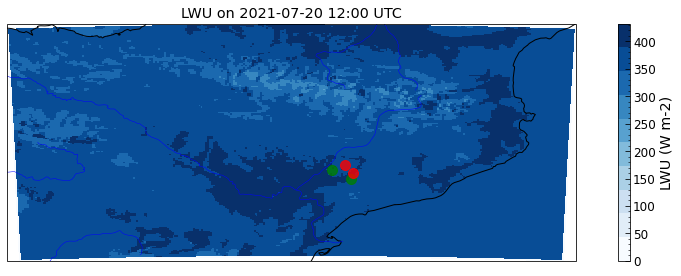

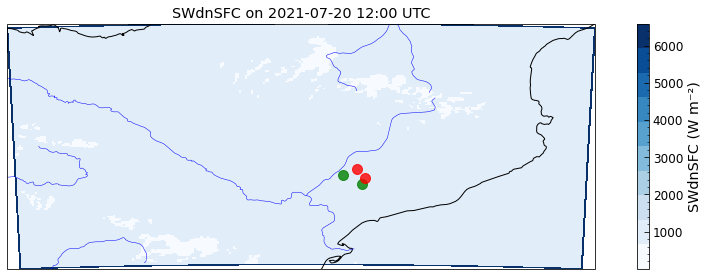

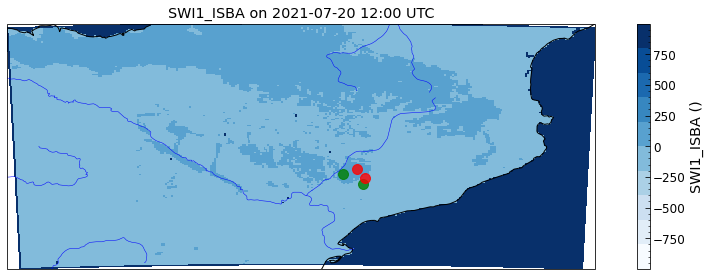

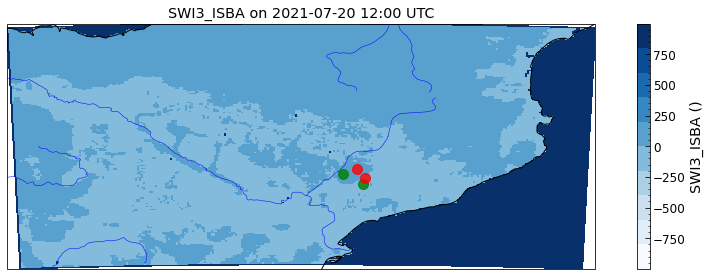

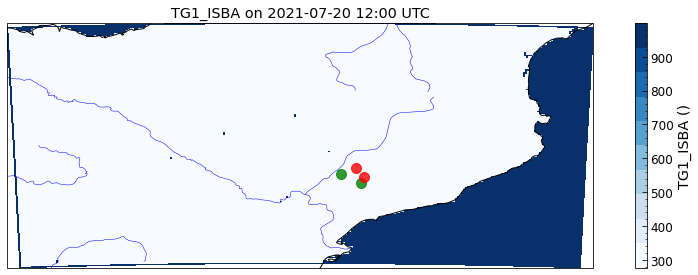

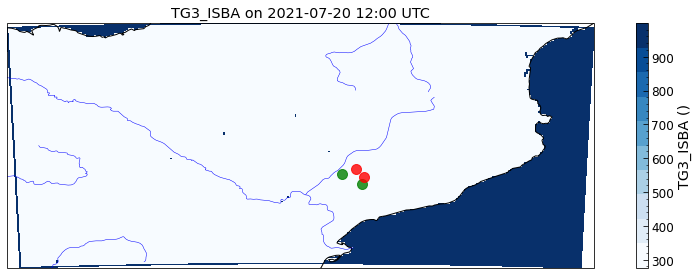

In [100]:
for var in varlist:
    vmin=0
    vmax=500
    vmin,vmax=None, None
    cmap=blues
    map_mesoNH_timestamp_restrict(ds_orig, 
                        var,
                        vmin=vmin, vmax=vmax, cmap=cmap,
                        timestamp='2021-07-20T12:00:00',
                        add_liaise=True,
                        # lon_min=0.6, 
                        # lon_max=1.4, 
                        # lat_min=41.37, 
                        # lat_max=41.92,
                        # poly=both_cells
                        )

/home/ptiengou/Documents/data_and_scripts/netcdf-scripts/python_notebooks/LMDZOR/../../python_tools/tools.py:616: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(polygon[:, 0], polygon[:, 1], 'r-', linewidth=2, c='red')


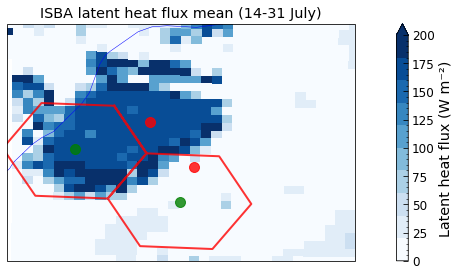

In [101]:
var='flat'
vmin=-0
vmax=200
# vmin,vmax=None, None
cmap=blues
map_mesoNH_mean_restrict(ds_orig, 
                 var,
                 vmin=vmin, vmax=vmax, cmap=cmap,
                 title='ISBA latent heat flux mean (14-31 July)',
                 add_liaise=True,
                lon_min=0.6, 
                lon_max=1.4, 
                lat_min=41.37, 
                lat_max=41.92,
                poly=both_cells,
                label='Latent heat flux (W m⁻²)',
                 )

# Subdataset for ICOLMDZ grid cells

In [102]:
ds_elsplans_cell= subset_dataset_by_polygon(ds_orig, elsplans_cell, 
                                            name='Els Plans_mesoNH_mean',
                                            plot_color='orange')
ds_cendrosa_cell= subset_dataset_by_polygon(ds_orig, cendrosa_cell, 
                                            name='Cendrosa_mesoNH_mean',
                                            plot_color='orange')

In [103]:
#select subdataset for precisely each site
cendrosa_exact = select_dataset_lon_lat(ds_orig, 
                                        lon=Cendrosa_Longitude, lat=Cendrosa_Latitude, 
                                        name='Cendrosa_mesoNH_exact',
                                        plot_color='purple')

In [104]:
elsplans_exact = select_dataset_lon_lat(ds_orig, 
                                        lon=ElsPlans_Longitude, lat=ElsPlans_Latitude, 
                                        name='Els Plans_mesoNH_exact', 
                                        plot_color='purple')

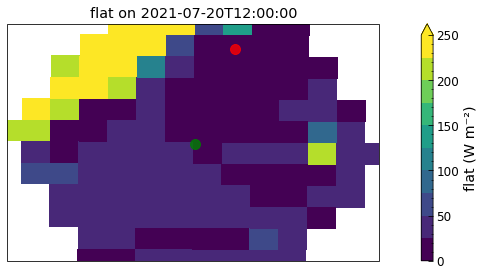

In [105]:
map_mesoNH_timestamp(ds_elsplans_cell,
                 var='flat',
                 vmin=0, vmax=250, cmap=myvir,
                #  title='Latent Heat Flux mean (14-31/07/2021) in Ebro basin',
                 add_liaise=True,
                 timestamp='2021-07-20T12:00:00',
                 )

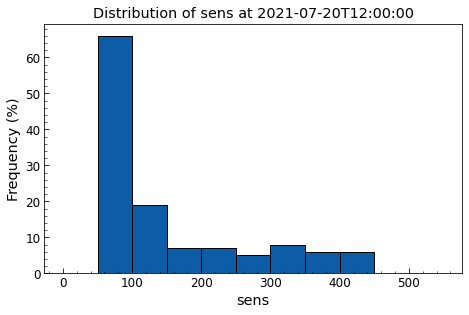

In [106]:
ds=ds_cendrosa_cell
# ds=ds_elsplans_cell
timestamp='2021-07-20T12:00:00'
var='sens'
xmin=0
xmax=550
nbins=11
bins_timestamp(ds, var, timestamp, nbins=nbins, xmin=xmin, xmax=xmax)

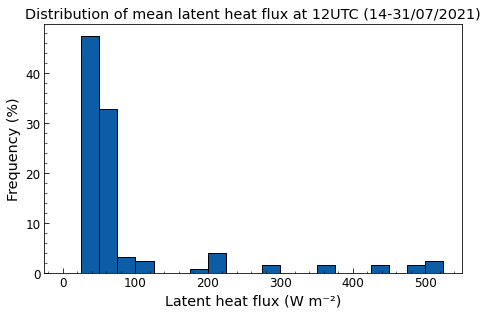

In [107]:
ds=ds_cendrosa_cell
ds=ds_elsplans_cell
# timestamp='2021-07-20T12:00:00'
var='flat'
xmin=0
xmax=525
nbins=21
title='Distribution of mean latent heat flux at 12UTC (14-31/07/2021)'
xlabel='Latent heat flux (W m⁻²)'
bins_hour(ds, var, 12, nbins=nbins, xmin=xmin, xmax=xmax, 
          title=title, xlabel=xlabel)

In [108]:
def mean_value_hour(ds, var, hour):
    """
    Calculate the mean value of a variable at a given hour.
    """
    ds_hour = ds.where(ds.time.dt.hour == hour).mean(dim='time')
    mean_value = ds_hour[var].mean().values
    return mean_value

In [109]:
vars=['flat', 'sens']
ds1=cendrosa_exact
ds2=ds_cendrosa_cell
ds3=cen_lmdz_noirr
ds4=cen_lmdz_irr100
ds5=cen_lmdz_routingfull_beta1
ds6=cen_mto

ds8=elsplans_exact
ds9=ds_elsplans_cell
ds10=els_lmdz_noirr
ds11=els_lmdz_irr100
ds12=els_lmdz_routingfull_beta1
ds13=els_mto

for var in vars:
    for ds in [ds1, ds2, ds3, ds4, ds5, ds6, ds8, ds9, ds10, ds11, ds12, ds13]:
            mean = mean_value_hour(ds, var, 12)
            print(f"{ds.name} - {var} at 12 UTC: {mean:.2f} W m⁻²")

NameError: name 'cen_lmdz_noirr' is not defined

# Time series

In [ ]:
var='flat'
ds=ds_orig
vmin=0
vmax=200
time_series_lonlat_mesoNH(ds, var, 
                          lon=ElsPlans_lon, 
                          lat=ElsPlans_lat,
                          vmin=vmin, vmax=vmax
                          )

In [ ]:
var='sens'
ds=ds_cendrosa_cell
ds=ds_elsplans_cell
vmin=0
vmax=200
vmin,vmax=None, None
time_series_ave_mesoNH(ds, var, 
                    #    vmin=vmin, vmax=vmax
                       )

# Compare with LMDZ

## Load LMDZ files

In [ ]:
# nat_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/hourly_native'
nat_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/halfhour_native'

rough_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/roughdyn_z0ratios'
boost_irrig_dir= '../../../JZ_simu_outputs/LAM/LAM_1500_60/boost_irrig'
change_pft_dir= '../../../JZ_simu_outputs/LAM/LAM_1500_60/change_pft'

In [ ]:
noirr=True
irr100=True
routing_restart_full_beta1=True


In [ ]:
#load LMDZ
if noirr:
    lmdz_noirr_file = '{}/sim267_20210701_20210731_HF_histhf.nc'.format(nat_dir)
    lmdz_noirr = format_lmdz_HF(lmdz_noirr_file, 'red', 'noirr')
    lmdz_noirr = lmdz_noirr.sel(time=slice('2021-07-14', '2021-07-30'))
    cen_lmdz_noirr, els_lmdz_noirr  , sop_cen_lmdz_noirr,   sop_els_lmdz_noirr = select_liaise_sites_sop(lmdz_noirr, 'no_irr')


In [ ]:
if irr100:
    dir=boost_irrig_dir
    sim_name='sim275'
    color='blue'
    label='irr'

    lmdz_irr100_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    lmdz_irr100 = format_lmdz_HF(lmdz_irr100_file, color, label)
    lmdz_irr100 = lmdz_irr100.sel(time=slice('2021-07-14', '2021-07-30'))
    cen_lmdz_irr100, els_lmdz_irr100  , sop_cen_lmdz_irr100,   sop_els_lmdz_irr100 = select_liaise_sites_sop(lmdz_irr100, label)


In [ ]:
if routing_restart_full_beta1 :
    dir=boost_irrig_dir
    sim_name='sim293'
    color='green'
    label='irr_boost'

    lmdz_routingfull_beta1_file = '{}/{}_20210701_20210731_HF_histhf.nc'.format(dir, sim_name)
    lmdz_routingfull_beta1 = format_lmdz_HF(lmdz_routingfull_beta1_file, color, label)
    lmdz_routingfull_beta1 = lmdz_routingfull_beta1.sel(time=slice('2021-07-14', '2021-07-30'))
    cen_lmdz_routingfull_beta1, els_lmdz_routingfull_beta1, sop_cen_lmdz_routingfull_beta1, sop_els_lmdz_routingfull_beta1 = select_liaise_sites_sop(lmdz_routingfull_beta1, label)

## Load obs

In [ ]:
#load all July obs in one ds
cen_mto_filename='../../../obs/LIAISE/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2/LIAISE_LA-CENDROSA_CNRM_MTO-FLUX-30MIN_L2_2021-07*_V3.nc'
cen_mto = format_Cendrosa_obs(cen_mto_filename)
cen_mto

In [ ]:
start_time = '2021-07-14T01:00:00'
end_time = '2021-07-30T23:00:00'
restrict_cen_mto = filter_xarray_by_timestamps(cen_mto, start_time, end_time)

In [ ]:
filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_20210721_V4.0.dat'
ds = dat_to_xarray(filename, 152, 153)
els_mto_2107 = format_ElsPlans_obs(ds, start_day='2021-07-21')

filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_20210722_V4.0.dat'
ds = dat_to_xarray(filename, 152, 153)
els_mto_2207 = format_ElsPlans_obs(ds, start_day='2021-07-22')

In [ ]:
july_days=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
for day in july_days:
    filename =  '../../../obs/LIAISE/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2/LIAISE_ELS-PLANS_UKMO_MTO-30MIN_L2_202107{}_V4.0.dat'.format(day)
    ds = dat_to_xarray(filename, 152, 153)
    day_els_mto = format_ElsPlans_obs(ds, start_day='2021-07-{}'.format(day))
    if day=='01':
        els_mto=day_els_mto
    else:
        els_mto=xr.concat([els_mto,day_els_mto],dim='time')
els_mto

In [ ]:
restrict_els_mto = filter_xarray_by_timestamps(els_mto, start_time, end_time)

## Time series of average

In [ ]:
var='SWdnSFC'
ds1= cen_lmdz_noirr
ds2= cen_lmdz_irr100
ds3= cen_lmdz_routingfull_beta1
ds4=ds_cendrosa_cell
ds5=cendrosa_exact
ds6=restrict_cen_mto

# ds1= els_lmdz_noirr
# ds2= els_lmdz_irr100
# ds3= els_lmdz_routingfull_beta1
# ds4=ds_elsplans_cell
# ds5=elsplans_exact
# ds6=restrict_els_mto

ds4.attrs['show_envelope'] = True

# ds1['q2m'].attrs['long_name'] = '2-m specific humidity'

ds_list= [ds1, ds2, ds3, ds5, ds4,  ds6]  
ds_list=[ds6, ds1, ds2, ds3]  

title=f'{ds1[var].attrs['long_name']} ({ds1[var].attrs['units']})'
if ds1[var].attrs['units'] == 'W/m2':
    title=f'{ds1[var].attrs["long_name"]} (W m⁻²)'

In [ ]:
vmin=-0
vmax=100
vmin,vmax=None, None


time_series_ave(ds_list, var, 
                vmin=vmin, vmax=vmax,
                title=title,
                legend_out=None,
                # xlabel='Time',
                # ylabel=ds1[var].attrs['long_name'],
                ds_colors=True,
                figsize=(12, 6),
                envelope=False
                )

In [ ]:
vmin=0
vmax=100
vmin,vmax=None, None

diurnal_cycle_ave(ds_list, var,
                 vmin=vmin, vmax=vmax,
                 title=title,
                 legend_out=None,
                #  xlabel='Time',
                #  ylabel=ds1[var].attrs['long_name'],
                 ds_colors=True,
                figsize=(5,5),
                envelope=True
                 )

In [ ]:
# #show single value in lmdz sims for one given timestamp
# var='sens'
# timestamp='2021-07-20T12:00:00'

# #cendrosa
# ds1= cen_lmdz_noirr
# ds2= cen_lmdz_irr100
# ds3= cen_lmdz_routingfull_beta1
# ds4=ds_cendrosa_cell
# ds5 = ds4.mean(dim=['ni', 'nj'])
# ds5.attrs['name'] = ds4.attrs['name']
# ds5.attrs['plot_color'] = ds4.attrs['plot_color']
# ds6=cendrosa_exact
# ds7=restrict_cen_mto
# ds_list= [ds1, ds2, ds3, ds5, ds6, ds7]

# for ds in ds_list:
#     if var in ds:
#         print(f"{ds.attrs['name']} {ds[var].sel(time=timestamp, method='nearest').values:.2f} {ds1[var].attrs['units']}")
#     else:
#         print(f"{ds.attrs['name']} does not have variable {var}")

# #els plans
# ds1= els_lmdz_noirr
# ds2= els_lmdz_irr100
# ds3= els_lmdz_routingfull_beta1
# ds4=ds_elsplans_cell
# ds5 = ds4.mean(dim=['ni', 'nj'])        
# ds5.attrs['name'] = ds4.attrs['name']
# ds5.attrs['plot_color'] = ds4.attrs['plot_color']
# ds6=elsplans_exact
# ds7=restrict_els_mto
# ds_list= [ds1, ds2, ds3, ds5, ds6, ds7]
# for ds in ds_list:
#     if var in ds:
#         print(f"{ds.attrs['name']} {ds[var].sel(time=timestamp, method='nearest').values:.2f} {ds1[var].attrs['units']}")
#     else:
#         print(f"{ds.attrs['name']} does not have variable {var}")